In [94]:
import pandas as pd
from imdb import IMDb
import pymysql.cursors
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn import tree
import re
import pydot
from IPython.display import Image
from pylab import rcParams
%matplotlib inline

I did this for resolving unicode problem. After saving files we dont need it.

In [2]:
import sys, os

# reload(sys)
# sys.setdefaultencoding('utf-8')

In [3]:
connection = pymysql.connect(host='localhost',
                             user='imdb',
                             password='imdb',
                             db='imdb',
                             charset='utf8mb4',
                             cursorclass=pymysql.cursors.DictCursor)

After making connection its time to run queries. Since running queries take a LOT of time I save them as csv for later use.

In [4]:
sql='''
SELECT 
    name.id,
    AVG(movie_info_idx.info) AS avg_actor_rating
FROM
    cast_info,
    name,
    role_type,
    title,
    movie_info_idx
WHERE
    cast_info.person_id = name.id
        AND role_type.id = cast_info.role_id
        AND title.id = cast_info.movie_id
        AND title.id = movie_info_idx.movie_id
        AND title.kind_id = 1
        AND (role_type.role = 'actor'
        OR role_type.role = 'actress')
        AND movie_info_idx.info_type_id = 101
GROUP BY name.id
'''

In this query I give each actor in database a score based on their past performaces. This score is based on the average score of all the movies they've participated in.

In [5]:
fname='actor_ratings.csv'
actor_ratings=''
if os.path.isfile(fname):
    actor_ratings = pd.read_csv(fname, index_col=0)
else:
    actor_ratings=pd.read_sql(sql, connection)
    actor_ratings.to_csv('actor_ratings.csv')

In [6]:
actor_ratings.count()

id                  1672187
avg_actor_rating    1672187
dtype: int64

In [7]:
sql='''
SELECT 
    title.id AS movie_id,
    name.id AS actor_id,
    name.name AS actor_name
FROM
    title,
    cast_info,
    role_type,
    name
WHERE
    title.id = cast_info.movie_id
        AND title.kind_id = 1
        AND role_type.id = cast_info.role_id
        AND name.id = cast_info.person_id
        AND title.production_year > 2010
        AND (role_type.role = 'actor'
        OR role_type.role = 'actress')
        AND cast_info.nr_order < 5
ORDER BY cast_info.nr_order
'''

This gives us 4 top characters actors of all movies produced after 2010

In [8]:
fname='actors_list.csv'
actors=''
if os.path.isfile(fname):
    actors = pd.read_csv(fname, index_col=0)
else:
    actors=pd.read_sql(sql, connection)
    actors.to_csv('actors_list.csv')

In [9]:
actors.count()

movie_id      256140
actor_id      256140
actor_name    256140
dtype: int64

In [10]:
sql='''
SELECT 
    title.id, title.title, title.production_year
FROM
    title
WHERE
    production_year > 2010 AND kind_id = 1;
'''

This gives us list of all movies produced after 2010

In [11]:
fname='movies_list.csv'
movies=''
if os.path.isfile(fname):
    movies = pd.read_csv(fname, index_col=0)
else:
    movies=pd.read_sql(sql, connection)
    movies.to_csv('movies_list.csv')

In [12]:
movies.count()

id                 315812
title              315812
production_year    315812
dtype: int64

In [13]:
sql='''
SELECT 
    name.id,
    AVG(movie_info_idx.info) AS avg_director_rating
FROM
    cast_info,
    name,
    role_type,
    title,
    movie_info_idx
WHERE
    cast_info.person_id = name.id
        AND role_type.id = cast_info.role_id
        AND title.id = cast_info.movie_id
        AND title.id = movie_info_idx.movie_id
        AND title.kind_id = 1
        AND role_type.role = 'director'
        AND movie_info_idx.info_type_id = 101
GROUP BY name.id
'''

In this query I give each director in database a score based on their past performaces. This score is based on the average score of all the movies they've directed.

In [14]:
fname='director_ratings.csv'
director_ratings=''
if os.path.isfile(fname):
    director_ratings = pd.read_csv(fname, index_col=0)
else:
    director_ratings=pd.read_sql(sql, connection)
    director_ratings.to_csv('director_ratings.csv')

In [15]:
director_ratings.count()

id                     119548
avg_director_rating    119548
dtype: int64

In [16]:
sql='''
SELECT 
    name.id,
    AVG(movie_info_idx.info) AS avg_writer_rating
FROM
    cast_info,
    name,
    role_type,
    title,
    movie_info_idx
WHERE
    cast_info.person_id = name.id
        AND role_type.id = cast_info.role_id
        AND title.id = cast_info.movie_id
        AND title.id = movie_info_idx.movie_id
        AND title.kind_id = 1
        AND role_type.role = 'writer'
        AND movie_info_idx.info_type_id = 101
GROUP BY name.id
'''

In this query I give each writer in database a score based on their past performaces. This score is based on the average score of all the movies they've written.

In [17]:
fname='writer_ratings.csv'
writer_ratings=''
if os.path.isfile(fname):
    writer_ratings = pd.read_csv(fname, index_col=0)
else:
    writer_ratings=pd.read_sql(sql, connection)
    writer_ratings.to_csv(fname)

In [18]:
writer_ratings.count()

id                   182876
avg_writer_rating    182876
dtype: int64

In [19]:
sql='''
SELECT 
    movie_id, info AS budget
FROM
    movie_info
        INNER JOIN
    title ON title.id = movie_info.movie_id
WHERE
    info LIKE '$%' AND info_type_id = 105
        AND title.kind_id = 1
        AND title.production_year > 2010;
'''

This gives us budget of all movies produced after 2010 (if available)

In [20]:
fname='budget_list.csv'
budget_list=''
if os.path.isfile(fname):
    budget_list = pd.read_csv(fname, index_col=0)
else:
    budget_list=pd.read_sql(sql, connection)
    budget_list.to_csv(fname)

In [21]:
budget_list.count()

movie_id    50871
budget      50871
dtype: int64

In [22]:
sql='''
SELECT 
    title.id AS movie_id,
    name.id AS director_id,
    name.name AS director_name
FROM
    title,
    cast_info,
    role_type,
    name
WHERE
    title.id = cast_info.movie_id
        AND title.kind_id = 1
        AND role_type.id = cast_info.role_id
        AND name.id = cast_info.person_id
        AND title.production_year > 2010
        AND role_type.role = 'director'
ORDER BY cast_info.nr_order
'''

List of director of movies produced after 2010

In [23]:
fname='directors_list.csv'
directors_list=''
if os.path.isfile(fname):
    directors_list = pd.read_csv(fname, index_col=0)
else:
    directors_list=pd.read_sql(sql, connection)
    directors_list.to_csv(fname)

In [24]:
directors_list.count()

movie_id         341913
director_id      341913
director_name    341913
dtype: int64

In [25]:
sql='''
SELECT 
    title.id AS movie_id,
    name.id AS writer_id,
    name.name AS writer_name
FROM
    title,
    cast_info,
    role_type,
    name
WHERE
    title.id = cast_info.movie_id
        AND title.kind_id = 1
        AND role_type.id = cast_info.role_id
        AND name.id = cast_info.person_id
        AND title.production_year > 2010
        AND role_type.role = 'writer'
ORDER BY cast_info.nr_order
'''

list of writers of movies produced after 2010

In [26]:
fname='writers_list.csv'
writers_list=''
if os.path.isfile(fname):
    writers_list = pd.read_csv(fname, index_col=0)
else:
    writers_list=pd.read_sql(sql, connection)
    writers_list.to_csv(fname)

In [27]:
writers_list.count()

movie_id       392614
writer_id      392614
writer_name    392614
dtype: int64

In [28]:
sql='''
SELECT 
    movie_id, info AS genre
FROM
    movie_info
        INNER JOIN
    title ON title.id = movie_info.movie_id
WHERE
    info_type_id = 3 AND title.kind_id = 1
        AND title.production_year > 2010;
'''

genre of movies produced after 2010

In [29]:
fname='genres_list.csv'
genres_list=''
if os.path.isfile(fname):
    genres_list = pd.read_csv(fname, index_col=0)
else:
    genres_list=pd.read_sql(sql, connection)
    genres_list.to_csv(fname)

In [30]:
genres_list.count()

movie_id    706768
genre       706768
dtype: int64

In [31]:
sql='''
SELECT 
    movie_id, info AS gross
FROM
    movie_info
        INNER JOIN
    title ON title.id = movie_info.movie_id
WHERE
    info LIKE '%(USA)%'
        AND title.kind_id = 1
        AND info_type_id = 107
        AND title.production_year > 2010;
'''

Gross income of movies produced after 2010 in US 

In [32]:
fname='gross_list.csv'
gross_list=''
if os.path.isfile(fname):
    gross_list = pd.read_csv(fname, index_col=0)
else:
    gross_list=pd.read_sql(sql, connection)
    gross_list.to_csv(fname)

In [33]:
gross_list.count()

movie_id    19612
gross       19612
dtype: int64

In [34]:
sql='''
SELECT 
    movie_id, info AS mpaa
FROM
    movie_info
        INNER JOIN
    title ON title.id = movie_info.movie_id
WHERE
    info_type_id = 97 AND title.kind_id = 1
        AND title.production_year > 2010;
'''

mpaa rating of movies produced after 2010

In [35]:
fname='mpaa_list.csv'
mpaa_list=''
if os.path.isfile(fname):
    mpaa_list = pd.read_csv(fname, index_col=0)
else:
    mpaa_list=pd.read_sql(sql, connection)
    mpaa_list.to_csv(fname)

In [36]:
mpaa_list.count()

movie_id    3483
mpaa        3483
dtype: int64

In [37]:
sql='''
SELECT 
    movie_id, info AS plot
FROM
    movie_info
        INNER JOIN
    title ON title.id = movie_info.movie_id
WHERE
    info_type_id = 98 AND title.kind_id = 1
        AND title.production_year > 2010;
'''

plot description of movies produced after 2010

In [38]:
fname='plot_list.csv'
plot_list=''
if os.path.isfile(fname):
    plot_list = pd.read_csv(fname, index_col=0)
else:
    plot_list=pd.read_sql(sql, connection)
    plot_list.to_csv(fname)

In [39]:
plot_list.count()

movie_id    79255
plot        79255
dtype: int64

In [40]:
sql='''
SELECT 
    movie_id, info AS vote
FROM
    movie_info_idx
        INNER JOIN
    title ON title.id = movie_info_idx.movie_id
WHERE
    info_type_id = 100 AND title.kind_id = 1
        AND title.production_year > 2010;
'''

number of votes in IMDB for movies produced after 2010

In [41]:
fname='votes_list.csv'
votes_list=''
if os.path.isfile(fname):
    votes_list = pd.read_csv(fname, index_col=0)
else:
    votes_list=pd.read_sql(sql, connection)
    votes_list.to_csv(fname)

In [42]:
votes_list.count()

movie_id    63618
vote        63618
dtype: int64

In [43]:
sql='''
SELECT 
    movie_id, info AS rating
FROM
    movie_info_idx
        INNER JOIN
    title ON title.id = movie_info_idx.movie_id
WHERE
    info_type_id = 101 AND title.kind_id = 1
        AND title.production_year > 2010;
'''

IMDB movies rating

In [44]:
fname='movie_ratings.csv'
movie_ratings=''
if os.path.isfile(fname):
    movie_ratings = pd.read_csv(fname, index_col=0)
else:
    movie_ratings=pd.read_sql(sql, connection)
    movie_ratings.to_csv(fname)

In [45]:
movie_ratings.count()

movie_id    63618
rating      63618
dtype: int64

In [46]:
# actors, directors_list, writers_list, budget_list, genres_list, gross_list, mpaa_list, plot_list, votes_list

Now since not all the movies in IMDB database is necesaty a movies we can see in theatres or professional moives, I'm going to try minimizing number of movies by joining them with other datasets.

In [47]:
actors.drop('actor_name', axis=1, inplace=True)
actor_ratings.columns = ['actor_id', 'avg_actor_rating']
actors = pd.merge(actors, actor_ratings, on='actor_id', how='left')

In [48]:
directors_list.drop('director_name', axis=1, inplace=True)
director_ratings.columns = ['director_id', 'avg_director_rating']
directors_list = pd.merge(directors_list, director_ratings, on='director_id', how='left')

In [49]:
writers_list.drop('writer_name', axis=1, inplace=True)
writer_ratings.columns = ['writer_id', 'avg_writer_rating']
writers_list = pd.merge(writers_list, writer_ratings, on='writer_id', how='left')

In [50]:
movies_list=movies.id.to_frame()
movies_list.columns=['movie_id']

In [51]:
movies_list=pd.merge(movies_list, actors, on='movie_id', how='left')
movies_list=pd.pivot_table(movies_list, 
                           index='movie_id', 
                           values='avg_actor_rating', 
                           aggfunc=np.mean).to_frame().reset_index().dropna()

In [52]:
movies_list=pd.merge(movies_list, directors_list, on='movie_id', how='left')
movies_list=pd.pivot_table(movies_list, 
                           index=['movie_id', 'avg_actor_rating'], 
                           values='avg_director_rating', 
                           aggfunc=np.mean).to_frame().reset_index().dropna()

In [53]:
movies_list=pd.merge(movies_list, writers_list, on='movie_id', how='left')
movies_list=pd.pivot_table(movies_list, 
                           index=['movie_id', 'avg_actor_rating', 'avg_director_rating'], 
                           values='avg_writer_rating', 
                           aggfunc=np.mean).to_frame().reset_index().dropna()

In [54]:
movies_list=pd.merge(movies_list, budget_list, on='movie_id', how='left').dropna()
movies_list.budget=movies_list.budget.apply(lambda x: float(re.sub("[^0-9]", "", x)))

In [55]:
movies_list=pd.merge(movies_list, genres_list, on='movie_id', how='left')
movies_list=pd.concat([movies_list, pd.get_dummies(movies_list.genre, prefix='genre')], axis=1)
movies_list.drop('genre', axis=1, inplace=True)
movies_list=pd.pivot_table(movies_list, 
                           index=['movie_id', 'avg_actor_rating', 
                                  'avg_director_rating', 'avg_writer_rating',
                                  'budget'
                                 ], 
                           aggfunc=np.sum).reset_index().dropna()

In [57]:
gross_list.gross= gross_list.gross.apply(lambda x: float(re.sub("[^0-9]", "", x.split(' ')[0])))
gross_list=pd.pivot_table(gross_list, index='movie_id', values='gross', aggfunc=np.sum).reset_index()
movies_list=pd.merge(movies_list, gross_list, on='movie_id', how='left').dropna()

In [59]:
def update_mppa(x):
    if x=='R' or x=='NC-17'or  x=='Rated':
        return 'R'
    elif x=='PG-13' or x=='PG-':
        return 'PG-13'
    elif x=='PG':
        return 'PG'
    else:
        return 1

In [60]:
mpaa_list.mpaa= mpaa_list.mpaa.apply(lambda x: x.split(' ')[1])
movies_list=pd.merge(movies_list, mpaa_list, on='movie_id', how='left').dropna()
movies_list.mpaa=movies_list.mpaa.apply(lambda x: update_mppa(x))
movies_list=pd.concat([movies_list, pd.get_dummies(movies_list.mpaa, prefix='rated')], axis=1)
movies_list.drop('mpaa', axis=1, inplace=True)

In [68]:
plot_list=pd.pivot_table(plot_list, index='movie_id', values='plot', aggfunc=lambda x: ' '.join(x)).reset_index()
movies_list=pd.merge(movies_list, plot_list, on='movie_id', how='left').dropna()
v=TfidfVectorizer(stop_words='english', max_features=30)
plot_tokens=v.fit_transform(movies_list['plot']).todense()
plot_tokens=pd.DataFrame(plot_tokens, columns=v.get_feature_names())
plot_tokens=plot_tokens.add_prefix('tokens_')
movies_list=pd.concat([movies_list, plot_tokens], axis=1).dropna()
movies_list=movies_list.drop('plot', axis=1)

In [ ]:
movies_list=pd.merge(movies_list, votes_list, on='movie_id', how='left').dropna()

In [75]:
movies_list.count()

movie_id               802
avg_actor_rating       802
avg_director_rating    802
avg_writer_rating      802
budget                 802
genre_Action           802
genre_Adventure        802
genre_Animation        802
genre_Biography        802
genre_Comedy           802
genre_Crime            802
genre_Documentary      802
genre_Drama            802
genre_Family           802
genre_Fantasy          802
genre_Game-Show        802
genre_History          802
genre_Horror           802
genre_Music            802
genre_Musical          802
genre_Mystery          802
genre_News             802
genre_Reality-TV       802
genre_Romance          802
genre_Sci-Fi           802
genre_Short            802
genre_Sport            802
genre_Talk-Show        802
genre_Thriller         802
genre_War              802
                      ... 
tokens_daughter        802
tokens_family          802
tokens_father          802
tokens_finds           802
tokens_friend          802
tokens_friends         802
t

As we can see number of movies has dramatically reduced and seems more reasonable.

In [76]:
from sklearn.preprocessing import LabelEncoder
from sklearn.cross_validation import cross_val_score, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.externals.six import StringIO
from sklearn.tree import export_graphviz
import pydot
from IPython.display import Image
import matplotlib.pyplot as plt
%matplotlib inline

In [82]:
# le = LabelEncoder()

In [78]:
x=movies_list

In [79]:
movie_ratings.rating=movie_ratings.rating.apply(lambda x: float(x))
y=pd.merge(movies_list, movie_ratings, on='movie_id', how='left').dropna()['rating']
y=y.apply(lambda x: 1 if x>7.0 else 0)
# y=le.fit_transform(y)

In [ ]:
# x_train, x_test, y_train, y_test=train_test_split(x, y)

In [81]:
def get_cv(target):
    return StratifiedKFold(target, n_folds=3, shuffle=True, random_state=41)
def score(model, data, target):
    model.fit(data, target)
    return model.score(data, target)
def grid_search(model, params, cv):
    return GridSearchCV(estimator=model, 
                    param_grid=params,
                    cv=cv
                   )
def evaluate_model(model, data, target, params=None):
    x_train, x_test, y_train, y_test=train_test_split(data, target, stratify=target)
#     print score(model, x_train, y_train), "\n"
    cv=get_cv(y_train)
    if params:
        grid=grid_search(model, params, cv)
    
        grid.fit(x_train, y_train)
        model = grid.best_estimator_
        print "Best Model after Grid Search:\n", model
        
    else:
        model.fit(x_train, y_train)
        
    s=cross_val_score(model, x_train, y_train, cv=cv, n_jobs=-1)
    print "Mean score of the model is: {}".format(s.mean())
    predictions = model.predict(x_test)
    
    print "Confusion Matrix:\n",confusion_matrix(y_test, predictions), "\n"
    print "Classification Report:\n", classification_report(y_test, predictions)
    return model

What the above functions do is first split the dataset to test and train and find the best model through grid search and cross validation and after that evalutates the best model on test data

In [83]:
params = {
    'max_depth': [None,1, 2, 3, 4, 5],
    'min_samples_split': [2, 10, 25, 50, 100],
}
dt=evaluate_model(DecisionTreeClassifier(), x, y, params)

Best Model after Grid Search:
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=100, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')
Mean score of the model is: 0.821820545514
Confusion Matrix:
[[136  10]
 [ 24  31]] 

Classification Report:
             precision    recall  f1-score   support

          0       0.85      0.93      0.89       146
          1       0.76      0.56      0.65        55

avg / total       0.82      0.83      0.82       201



As we can see our decision tree clasifier was able to classify test data with 82%

In [88]:
import pydotplus

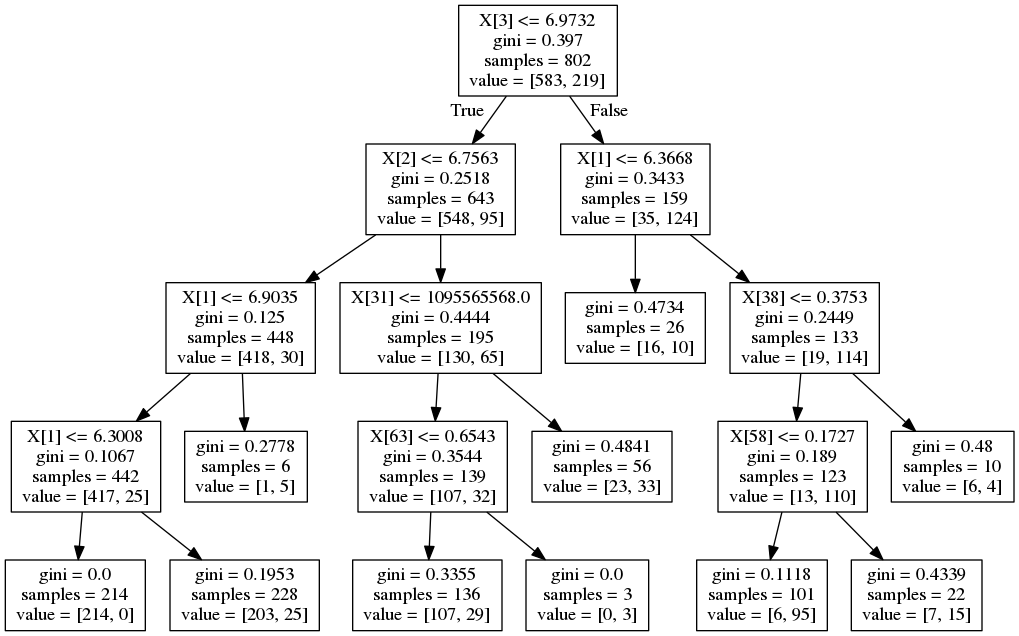

In [90]:
dt=dt.fit(x, y)
tree.export_graphviz(dt, out_file='dt.dot')
graph= pydotplus.graph_from_dot_file('dt.dot')
graph.write_png('dt.png')
Image(filename='dt.png') 

In [91]:
params = {
    'n_estimators': [10, 20, 50, 100, 200],
    'max_depth': [None,1, 2, 3, 4, 5],
    'min_samples_split': [2, 10, 25, 50, 100],
}
rf=evaluate_model(RandomForestClassifier(class_weight='balanced', n_jobs=-1), x, y)

Mean score of the model is: 0.806995174879
Confusion Matrix:
[[140   6]
 [ 24  31]] 

Classification Report:
             precision    recall  f1-score   support

          0       0.85      0.96      0.90       146
          1       0.84      0.56      0.67        55

avg / total       0.85      0.85      0.84       201



With random forest we get score of 0.80 but precision, recall and f1_score are much higher which tells us random forest has lower over-fitting and generally better results

Now we can see feature importance in random forest

(-1, 66)

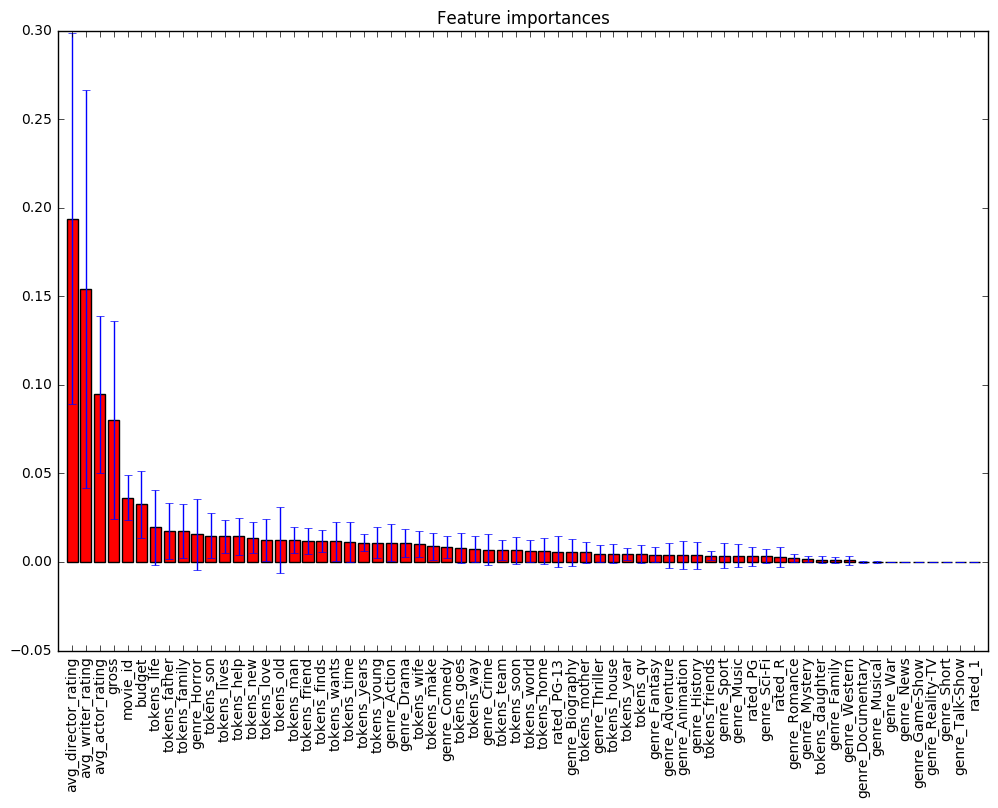

In [96]:
rf.fit(x, y)
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
indices = np.argsort(importances)[::-1]
feature_names = x.columns
# Plot the feature importances of the forest
rcParams['figure.figsize'] = 12, 8
plt.figure()
plt.title("Feature importances")
plt.bar(range(x.shape[1]), importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(x.shape[1]), feature_names[indices], rotation=90)
plt.xlim([-1, x.shape[1]])

In [98]:
params = {
    'n_estimators': [10, 20, 50, 100, 200],
    'max_depth': [None,1, 2, 3, 4, 5],
    'min_samples_split': [2, 10, 25, 50, 100],
}
et=evaluate_model(ExtraTreesClassifier(class_weight='balanced', n_jobs=-1), x, y, params)

Best Model after Grid Search:
ExtraTreesClassifier(bootstrap=False, class_weight='balanced',
           criterion='gini', max_depth=None, max_features='auto',
           max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)
Mean score of the model is: 0.803695092377
Confusion Matrix:
[[140   6]
 [ 31  24]] 

Classification Report:
             precision    recall  f1-score   support

          0       0.82      0.96      0.88       146
          1       0.80      0.44      0.56        55

avg / total       0.81      0.82      0.80       201



(-1, 66)

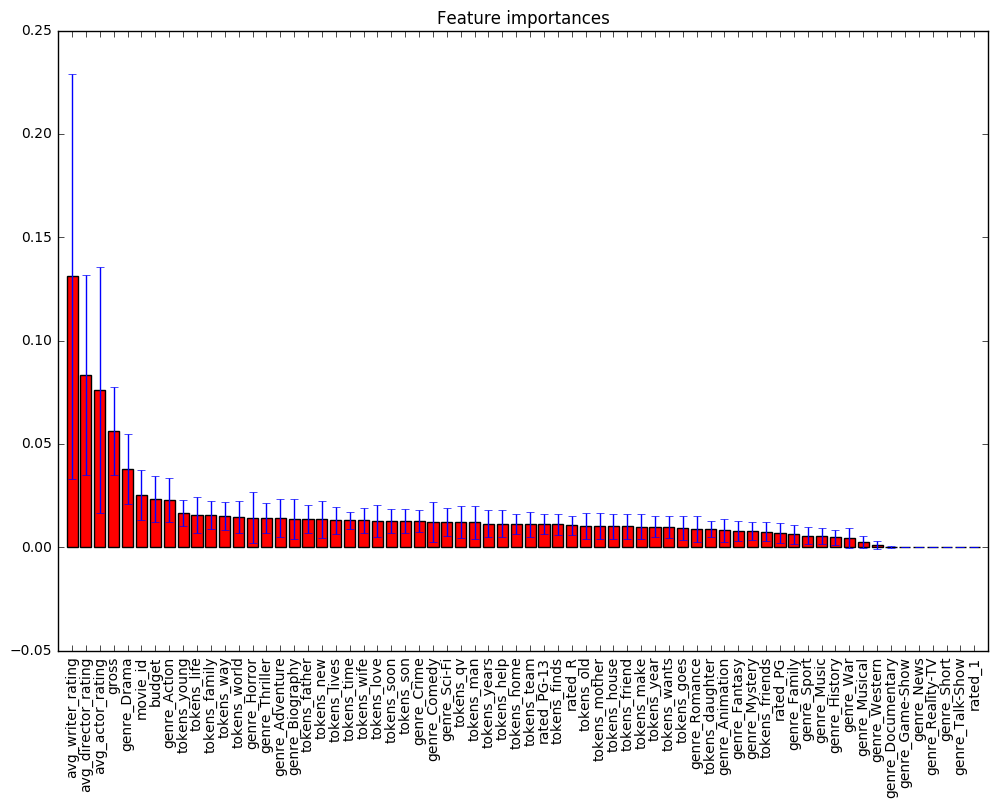

In [99]:
et.fit(x, y)
importances = et.feature_importances_
std = np.std([tree.feature_importances_ for tree in et.estimators_], axis=0)
indices = np.argsort(importances)[::-1]
feature_names = x.columns
# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(x.shape[1]), importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(x.shape[1]), feature_names[indices], rotation=90)
plt.xlim([-1, x.shape[1]])